# daWUAP - Economic Modeling with Stochastic Data Assimilation

**Author:** K. Arthur Endsley and Marco Maneta  
**Date:** August 2020

This is just one of many daWUAP interactive demos. See also:

- [Hydrologic Modeling Demo](https://www.umt.edu/hydro-econ-ag/crop-water/demo_hydrology.html)
- [Economic Modeling with Positive Mathematical Programming (PMP)](https://www.umt.edu/hydro-econ-ag/crop-water/demo_econ_pmp.html)
- [Economic Modeling with Stochastic Data Assimilation](https://www.umt.edu/hydro-econ-ag/crop-water/demo_econ_stochastic.html)

## Introduction

This notebook demonstrates how to use daWUAP to calibrate and run an economic model of water- and land-constrained agricultural production using **stochastic data assimilation (a Kalman filter).** This is one of two options for calibrating and running scenarios of agricultural production with daWUAP, the other option being positive mathematical programming. The demonstration covers:

- **Generating an initial ensemble of model parameters** through "spin-up," or repeated assimilation of the initial year of observations;
- **Assimilating new data for subsequent years** to better identify model parameters and variance in parameters;
- **Use of parallel processing** to assimilate data more efficiently for a large number of independent farms;
- **Plotting the results of stochastic data assimilation** to visualize the variation in model parameters;
- How to **create a Scenario data dictionary** describing constraints and market conditions;
- **Running an economic Scenario** with a stochastic ensemble of realizations.

**Table of Contents**

1. [**Setup**](#Setup)
1. [**Model Calibration with Stochastic Data Assimilation**](#Model-Calibration-with-Stochastic-Data-Assimilation)
  1. [Requirements](#Requirements)
  1. [Overview of Model Calibration](#Overview-of-Model-Calibration)
  1. [Calibration Setup](#Calibration-Setup)
  1. [Model Initialization and Spin-Up](#Model-Initialization-and-Spin-Up)
  1. [Assimilating New Observations](#Assimilating-New-Observations)
  1. [Continuous Data Assimilation](#Continuous-Data-Assimilation)
1. [**Parallel Calibration**](#Parallel-Calibration)
  1. [Defining the Parallel Calibration Process](#Defining-the-Parallel-Calibration-Process)
  1. [Concurrent Spin-Up](#Concurrent-Spin-Up)
  1. [Concurrent Data Assimilation](#Concurrent-Data-Assimilation)
1. [**Plotting the Calibration Results**](#Plotting-the-Calibration-Results)
1. [**Running a Scenario with Stochastic Data Assimilation**](#Running-a-Scenario-with-Stochastic-Data-Assimilation)
  1. [Generating Scenario Data](#Generating-Scenario-Data)
  1. [Running a Scenario](#Running-a-Scenario)
  1. [Plotting the Results](#Plotting-the-Results)
  1. [Baseline Comparison](#Baseline-Comparison)

## Setup

In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Model Calibration with Stochastic Data Assimilation

The first step in running the economic module is calibration against observed land and water allocations made by farmers, for each crop type.

### Requirements

For model calibration, we need:

- **Farm Definitions JSON file:** A JSON dictionary, `Farms.json`, which describes what farms are present, the crops they grow... It has one key, "farms", which is a list of the farms. Each farm has a number of attributes. The farm `id` links the farm to its polygon feature in the Farms Location GeoJSON file. Later, the model will ask for what field in the GeoJSON file corresponds to the farmers/ water users: the `water_user_id` field. The `source_id` is the node in the river network from which that farm draws water. The `parameters` and `simulated_states` are initially set to zero--these are what are going to be estimated by the hydro-economic model.
- **Observations JSON file:** A JSON dictionary describing the costs per unit area or unit volume of land and water for each crop type in each year for which we want to calibrate. In the stochastic approach, a running mean across the years is calculated. In the PMP approach, only one year of data is used; this might be a representative year or a synthetic year, using observations from multiple different (actual) years.

Each of these JSON files contains one or more data dictionaries describing the characteristics of a farm or observations of water and land allocations at a farm.

*These files have been provided for this demo.* When calibrating and running scenarios for your own region of interest, you can use the functions in `daWUAP.utils.fixtures` to generate data dictionary templates for Farms, Observations, and Scenarios.

### Overview of Model Calibration

In stochastic data assimilation, we are able to update the model fit with observations from multiple years. This permits us to refine the calibration by assimilating new data. For example, we may have a calibration that is used for simulation up through the current year; when new data are available next year, we can refine our calibraiton further.

**To calibrate our model using stochastic data assimilation:**

1. We use the first year of observation data (here, 2008) to initialize our `KalmanFilter` instance, creating ~300 samples of the parameter distribution for each farm.
2. To further initialize our ensemble of parameter estimates, we will "spin-up" by cycling the first year of observations (2008) ~20 times; essentially, we are presenting the same observations (from 2008) repeatedly to the Kalman filter.
3. Next, we will assimilate the data from each successive year (2009, 2010, ...).
4. Finally, we may need to adjust hyper-parameter values in order to get a nice level of variance in the parameter estimates. This is optional and will definitely depend on your data and your needs.

In Step 1, we create ~300 samples of the parameter distribution for each farm; each of the 300 samples has a normal distribution with mean based on the `Farm` object and standard deviation as the product of the mean and coefficient of variation.

**Because this process can be slow, here, for the sake of demonstration, we will take some shortcuts: We'll spin-up only 3 cycles before assimilating just a couple of years of additional data.** We can speed up the task by splitting it into independent steps that are executed in parallel, which we'll soon see.

### Calibration Setup

Here, we create a directory `KF_OUTPUT_DIR` to hold the output from our ensemble of stochastic data assimilations.

In [2]:
from daWUAP.econengine import Farm
from daWUAP.assimilation.kalmanfilter import KalmanFilter
import json
import os
import numpy as np

N_SPIN_UP = 3 # Number of spin-up cycles
N_SAMPLES = 100 # Number of samples of the parameter distribution

# Create a directory to store the assimilation output
KF_OUTPUT_DIR = './kf_ensembles'
try:
    os.mkdir(KF_OUTPUT_DIR)
except FileExistsError:
    for file in os.listdir(KF_OUTPUT_DIR):
        os.remove(os.path.join(KF_OUTPUT_DIR, file))
    
# Open farmers file
with open('./economic_inputs/Farms.json', 'r') as file:
    all_farms = json.load(file)

### Model Initialization and Spin-Up

We can perform steps 1 and 2 at the same time, where `if i > 0` tests for whether or not this is the very first data assimilation for the given farm. After the first step (`i == 0`), we want to load the `kf_info` file for that farm instead of re-initializing the ensemble of parameter distributions. If we did not re-load the `kf_info` file for each spin-up, then our parameter distribution would never improve!

In [3]:
with open('./observations/observations2008.json') as file:
    observations = json.load(file)
    
for record in all_farms['farms']:
    
    print('Initializing farm %s...' % record['id'])
    farm = Farm(**record)
    
    # Find the observation record with this Farm's id
    obs = list(filter(lambda r: r['id'] == farm.id, observations)).pop()
    
    # Step 1: Initialize a KalmanFilter instance for each farm
    # To initialize each farm's Kalman filter, define the number of ensembles
    #   to approximate the parameter distribution; this initializes the prior 
    #   distribution for each of 300 samples.
    kf = KalmanFilter(farm, 300, xi = 0.50, cv = 3.0)
    
    for i in range(0, N_SPIN_UP):
        print('-- Spin-up cycle %d of %d...' % (i + 1, N_SPIN_UP))
        # If this is not the first cycle, read the existing kf_info file
        if i > 0:
            kf = KalmanFilter(
                farm, fn_info_file = os.path.join(KF_OUTPUT_DIR, '%s_kf_info.json' % str(farm.id)))
            
        # Step 1 and 2: Assimilate data, either for the first time or for each
        #   successive spin-up
        kf.assimilate(obs, obs_var_scale_factor = 1)
        # Save the posterior distribution history and innovations; if no timestamp_label
        #   is specified, it will be assigned the numeric index of this assimilation
        kf.save_kalman_filter(KF_OUTPUT_DIR, timestep_label = str(i))

Initializing farm 30023...
-- Spin-up cycle 1 of 3...
-- Spin-up cycle 2 of 3...
-- Spin-up cycle 3 of 3...
Initializing farm 30039...
-- Spin-up cycle 1 of 3...
-- Spin-up cycle 2 of 3...
-- Spin-up cycle 3 of 3...
Initializing farm 30049...
-- Spin-up cycle 1 of 3...
-- Spin-up cycle 2 of 3...
-- Spin-up cycle 3 of 3...
Initializing farm 30061...
-- Spin-up cycle 1 of 3...
-- Spin-up cycle 2 of 3...
-- Spin-up cycle 3 of 3...
Initializing farm 30063...
-- Spin-up cycle 1 of 3...
-- Spin-up cycle 2 of 3...
-- Spin-up cycle 3 of 3...
Initializing farm 30077...
-- Spin-up cycle 1 of 3...
-- Spin-up cycle 2 of 3...
-- Spin-up cycle 3 of 3...
Initializing farm 30081...
-- Spin-up cycle 1 of 3...
-- Spin-up cycle 2 of 3...
-- Spin-up cycle 3 of 3...
Initializing farm 30093...
-- Spin-up cycle 1 of 3...
-- Spin-up cycle 2 of 3...
-- Spin-up cycle 3 of 3...


### Assimilating New Observations

Finally, we're ready to assimilate new data from new years of observations!

In [4]:
# We already assimilated 2008 in the spin-up, so start at 2009
observation_years = range(2009, 2018) 
calibrated_farms = {'farms': []}

for i, year in enumerate(observation_years):
    print('Calibrating on observations in year %d...' % year)

    # Open observed activity files for a given year
    with open('./observations/observations%d.json' % year) as file:
        observations = json.load(file)

    for record in all_farms['farms']:
        farm = Farm(**record)
        obs = list(filter(lambda r: r['id'] == farm.id, observations)).pop()
        kf = KalmanFilter(
            farm, fn_info_file = os.path.join(KF_OUTPUT_DIR, '%s_kf_info.json' % str(farm.id)))
            
        farm_dict = kf.assimilate(obs, obs_var_scale_factor = 1)
        
        # Save the posterior distribution history and innovations; if no timestamp_label
        #   is specified, it will be assigned the numeric index of this assimilation
        kf.save_kalman_filter(KF_OUTPUT_DIR, timestep_label = str(year))
        
        # Write out the calibrated farm data which, in the final year, will be the
        #   optimal model parameters
        if year == observation_years[-1]:
            calibrated_farms['farms'].append(farm_dict)
            
# Save calibrated farms
with open('./calibrated_Farms.json', 'w') as file:
     json.dump(calibrated_farms, file)

Calibrating on observations in year 2009...
Calibrating on observations in year 2010...
Calibrating on observations in year 2011...
Calibrating on observations in year 2012...
Calibrating on observations in year 2013...
Calibrating on observations in year 2014...
Calibrating on observations in year 2015...
Calibrating on observations in year 2016...
Calibrating on observations in year 2017...


**We now have a JSON file with the calibrated farms, describing the empirical relationships regarding farmer decisions learned in the economic model.**

Two other files are generated (and their paths described in the `kf_info` file):

- Posterior parameters (CSV) file, which has 300 samples of the posterior distribution of each parameter and the entire history of assimilation;
- Innovations file, which has the differences between the model prediction and the observation for each sample;

### Continuous Data Assimilation

**One of the key features of stochastic data assimilation is that we can update an existing model calibration as new data become continuously available.** More specifically, in this current example we have calibrated the model using data through year 2017. If we just finished collecting new data in 2018, we don't need to go back and re-assimilate the data from prior years. **Assimilating the new 2018 data can be done in a single step.**

In [5]:
with open('./observations/observations2018.json') as file:
    observations_2018 = json.load(file)

calibrated_farms = {'farms': []}
for record in all_farms['farms']:
    farm = Farm(**record)
    obs = list(filter(lambda r: r['id'] == farm.id, observations)).pop()
    # Load the existing calibration data (from years 2008-2017)
    kf = KalmanFilter(
        farm, fn_info_file = os.path.join(KF_OUTPUT_DIR, '%s_kf_info.json' % str(farm.id)))
    farm_dict = kf.assimilate(obs, obs_var_scale_factor = 1)
    kf.save_kalman_filter(KF_OUTPUT_DIR, timestep_label = '2018')
    calibrated_farms['farms'].append(farm_dict)

## Parallel Calibration

Above, we saw every step of the model calibration process. We're now ready to run scenarios or to [visualize the results of calibration.](#Plotting-the-Calibration-Results). 

However, calibration with stochastic data assimilation can be computationally intensive. Is there a way to make model calibration take less time? Yes! **Because the calibration of each farm is done independently of the others, we can calibrate them in parallel for each year.** It's not possible to calibrate years in parallel because the assimilation of new data depends on the assimilations from prior years.

### Defining the Parallel Calibration Process

To enable parallel calibration, we need to create a helper function, `assimilate()` that does the work of assimilating a single year of observation data for a single farm. This is the basic operation that will be performed, in parallel, for each year of observation data.

In [2]:
import json
import os
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from daWUAP.econengine import Farm
from daWUAP.assimilation.kalmanfilter import KalmanFilter

N_PROCESSES = 8 # Should equal the maximum number of CPUs you want to use

KF_OUTPUT_DIR = './kf_ensembles'
try:
    os.mkdir(KF_OUTPUT_DIR)
except FileExistsError:
    for file in os.listdir(KF_OUTPUT_DIR):
        os.remove(os.path.join(KF_OUTPUT_DIR, file))
        
def assimilate(data, year, de_novo = False):
    'Assimilates data for a farm from a given year'
    # "data" is a tuple containing (farm_record, obs)
    farm_record, obs = data
    farm = Farm(**farm_record)
    if de_novo:
        kf = KalmanFilter(farm, 300, xi = 0.50, cv = 3.0, q_mult = 0.5)
    else:
        kf = KalmanFilter(
            farm, fn_info_file = os.path.join(KF_OUTPUT_DIR, '%s_kf_info.json' % str(farm.id)))
    kf.assimilate(obs, obs_var_scale_factor = 1)
    kf.save_kalman_filter(KF_OUTPUT_DIR, timestep_label = str(year))
    return farm.write_farm_dict()

The `assimilate()` helper function takes a first argument, `data` that is a tuple of `(farm_record, obs)`. Packaging both the `Farm` record/ data dictionary *and* the observations data for the given year allows each process to work independently. We do this, below, with:

```py
# Zip two lists together; if they are sorted the same way, 
#   each farm lines up with the correct observation
zip(farms_by_id, observations_by_id)
```

### Concurrent Spin-Up

**One key thing to note about working in parallel is that the function each separate process performs, `assimilate()` needs to be modified slightly in each cycle (or each year).** We use the `partial()` function to make a *copy* of `assimilate()` with a hard-coded `year` argument; this copy, `assimilate_this_cycle()` can then be given to each separate process.

In [3]:
N_SPIN_UP = 20

with open('./economic_inputs/Farms.json', 'r') as file:
    all_farms = json.load(file)
    
# Get the farms in a specific order (ordered by ID)
farms_by_id = all_farms['farms']
farms_by_id.sort(key = lambda f: f['id'])
    
# Model initialization and spin-up
with open('./observations/observations2008.json') as file:
    observations_by_id = json.load(file)    
    # Get the observations in a specific order
    observations_by_id.sort(key = lambda o: o['id'])
    
for i in range(0, N_SPIN_UP):
    print('Spin-up %d of %d...' % (i + 1, N_SPIN_UP))
    
    # Create a copy of the assimilate() function that knows which cycle we're on
    #   and knows NOT to look for a kf_info file if it's the first cycle (de_novo = True)
    if i == 0:
        assimilate_this_cycle = partial(assimilate, year = str(i), de_novo = True)
    else:
        assimilate_this_cycle = partial(assimilate, year = str(i))
    
    with ProcessPoolExecutor(max_workers = N_PROCESSES) as executor:
        results = executor.map(assimilate_this_cycle, zip(farms_by_id, observations_by_id))

Spin-up 1 of 20...
Spin-up 2 of 20...
Spin-up 3 of 20...
Spin-up 4 of 20...
Spin-up 5 of 20...
Spin-up 6 of 20...
Spin-up 7 of 20...
Spin-up 8 of 20...
Spin-up 9 of 20...
Spin-up 10 of 20...
Spin-up 11 of 20...
Spin-up 12 of 20...
Spin-up 13 of 20...
Spin-up 14 of 20...
Spin-up 15 of 20...
Spin-up 16 of 20...
Spin-up 17 of 20...
Spin-up 18 of 20...
Spin-up 19 of 20...
Spin-up 20 of 20...


The `results` variable is a generator that yields the return value of the mapped function, `assimilate_this_cycle()`, for each process. **Because this was just the spin-up, we don't really care about the results: all that matters is the `kf_info` files.** So we can ignore `results` for now, but we'll come back to it soon.

### Concurrent Data Assimilation

We're now ready to assimilate data for all available years, in parallel for each farm.

In [4]:
for i, year in enumerate(range(2009, 2019)):
    print('Calibrating on observations in year %d...' % year)
    
    # Open observed activity files for a given year
    with open('./observations/observations%d.json' % year) as file:
        observations = json.load(file)
        # Get the observations in a specific order
        observations_by_id.sort(key = lambda o: o['id'])
        
    with ProcessPoolExecutor(max_workers = N_PROCESSES) as executor:
        assimilate_this_year = partial(assimilate, year = year)
        results = executor.map(assimilate_this_year, zip(farms_by_id, observations_by_id))

Calibrating on observations in year 2009...
Calibrating on observations in year 2010...
Calibrating on observations in year 2011...
Calibrating on observations in year 2012...
Calibrating on observations in year 2013...
Calibrating on observations in year 2014...
Calibrating on observations in year 2015...
Calibrating on observations in year 2016...
Calibrating on observations in year 2017...
Calibrating on observations in year 2018...


**Note:** There is some overhead in setting up the `ProcessPoolExecutor` for each new year/ cycle of observations. This detracts somewhat from the overall speed-up of parallelization and it's even possible, if the number of farms is small, that it won't really speed things up at all. However, as the number of farms grows, parallel execution of assimilation becomes much faster than the non-parallel version.

The `results` variable is a generator that yields the return value of the mapped function, `assimilate_this_year()`, for each process. In this case, we asked for as many processes as there are farms (8), so when we collect the final `results` with `list(results)`, we get a list of each of the calibrated farms. If you have fewer processes than farms, you will need to do just a little more work to unpack the results.

In [5]:
calibrated_farms = list(results)

# Save calibrated farmsx
with open('./calibrated_Farms2.json', 'w') as file:
     json.dump({'farms': calibrated_farms}, file)

In [10]:
len(calibrated_farms)

8

**We can also see that the results from the new, parallel version of stochastic data assimilation...**

In [11]:
print(calibrated_farms[0]['id'])
calibrated_farms[0]['parameters']['betas']

30023


[[0.39378551412471663, 0.5308162555171578],
 [0.45739206128887583, 0.43400716570125114],
 [0.7586206774198977, 0.27889450291625417],
 [0.8836679999076739, 0.12745704454869328],
 [0.6982886630983728, 0.28016617004197514],
 [0.8492928410785994, 0.17020321173016456],
 [0.6072931902877361, 0.3632231875137003]]

**...Are broadly similar to what we obtained from the serial version although, importantly, they are not the same because the assimilation is stochastic.**

In [12]:
with open('./calibrated_Farms.json', 'r') as file:
     calibrated_farms0 = json.load(file)

In [13]:
print(calibrated_farms0['farms'][0]['id'])
calibrated_farms0['farms'][0]['parameters']['betas']

30023


[[0.5132327166367899, 0.49002217828313294],
 [0.5106908465436936, 0.47079384683272596],
 [0.8671880462551097, 0.14006208086970418],
 [0.9547502909901249, 0.042524361084422604],
 [0.6857103474136119, 0.3063723104138024],
 [0.8467781210007553, 0.17156546462327207],
 [0.5634602717505452, 0.4473854504511367]]

## Plotting the Calibration Results

The primary benefit of stochastic data assimilation, as opposed to PMP, for model calibration is that we can quantify and visualize the variance in model parameters. Too much variance in a parameter's estimated value might mean the parameter is not well-identified: we can't be sure we have enough information to accurately simulate economic behavior involving that parameter. A moderate amount of variance, however, illustrates the uncertainty in a parameter and helps inform the range of possible outcomes in a simulation.

In [14]:
import os
from matplotlib import pyplot
from daWUAP.plotting import EnsembleResults

KF_OUTPUT_DIR = './kf_ensembles'

farm_id = '30023'
ens_results = EnsembleResults(os.path.join(KF_OUTPUT_DIR, '%s_kf_info.json' % str(farm_id)))

# Read in and report crop names from the ensemble
df = ens_results.load_ensemble()

# Report the parameter names
print(ens_results.get_parameter_names(df).tolist())

['betas', 'deltas', 'first_stage_lambda', 'lambdas_land', 'mus']


For example, below, we visualize the share factors, $\beta_j$, of two crops for each input $j$, land (red line) and water (blue line), across the ensemble. We can see that early in the calibration spin-up, through about 4th spin-up cycle in either crop, the share factors for land and water are estimated to be very close together, with high uncertainty. In the non-irrigated crop, these share factors are both close to parity by the end of assimilation. In the irrigated crop, the share factor for water (by the end of assimilation) is estimated to be significantly higher than that of land, which is to be expected because the irrigated crop requires substantial water inputs.

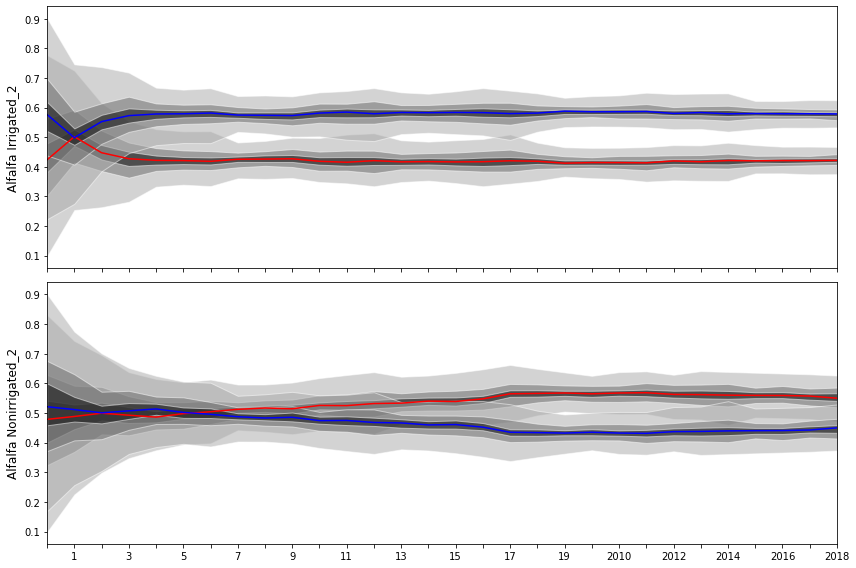

In [15]:
fig, ax, _ = ens_results.plot_parameter_ensemble(
    False, ['Alfalfa Irrigated', 'Alfalfa Nonirrigated'], ['betas'], figsize = (12, 8))
pyplot.show()

We could also examine the marginal value of production for each crop type: the additional revenue farmers would receive per additional unit of crop, could they produce it, for a unit input of land or water. Because the irrigated crops are water-limited, the marginal cost of production with respect to land is estimated to be zero for these crops. These crops also have a negative marginal value of production w.r.t water: the more water they apply, the lower their net revenue. Conversely, non-irrigated alfalfa could benefit net revenues if more water could be applied. Non-irrigated spring wheat would also boost net revenues if more land could be allocated.

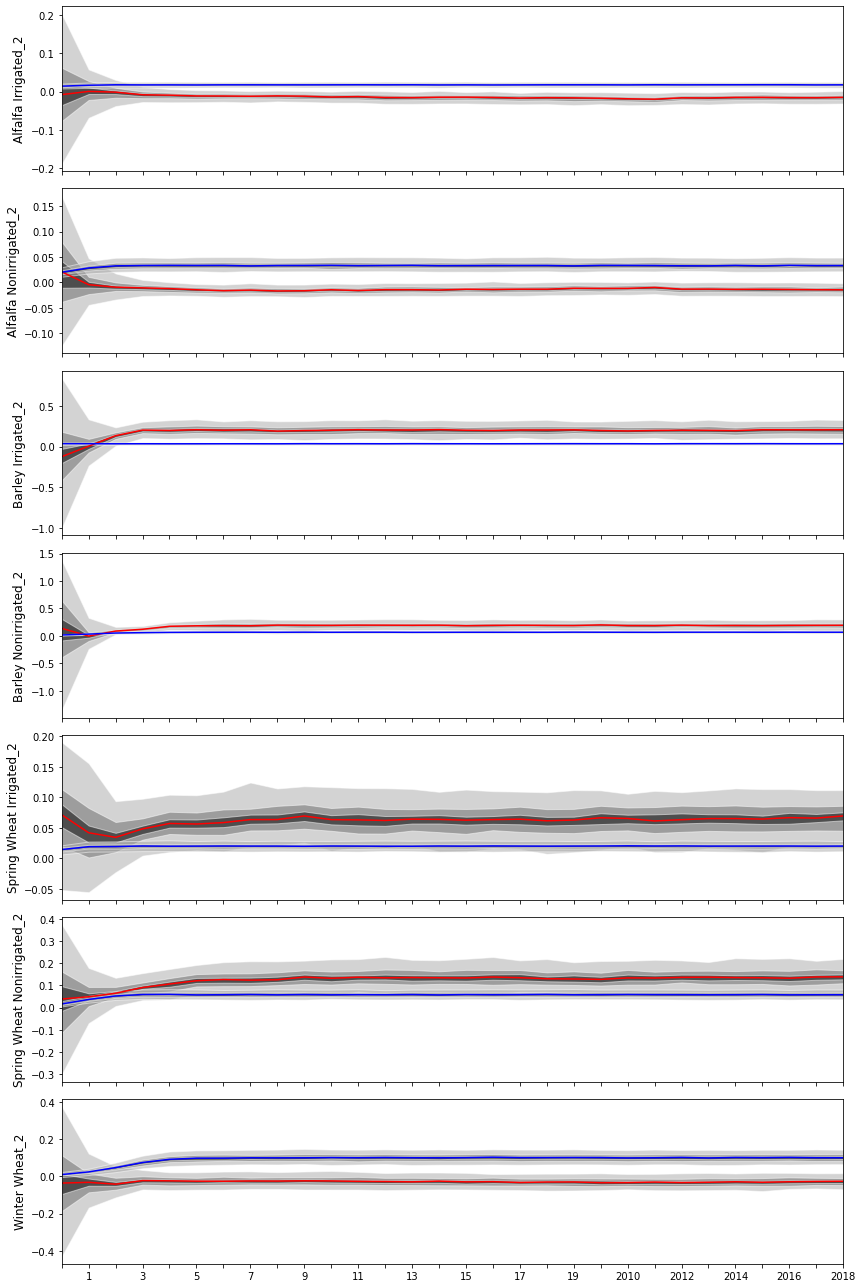

In [16]:
fig, ax, _ = ens_results.plot_parameter_ensemble(False, param_list = ['lambdas_land'], figsize = (12, 18))
pyplot.show()

## Running a Scenario with Stochastic Data Assimilation

The `Scenarios.json` file describes the climatic, economic, and policy conditions that prevail during the scenario we want to run. The keys of the `Scenarios.json` file have similar meanings to those in the observations JSON file but prescribe different values according to the desired scenario.

- `mean_costs` quantify the cost of cultivating land and water per crop type per unit area (dollars/ hectare) or volume (dollars/ mm-hectare).
- `crop_start_date`, `crop_cover_date`, and `crop_end_date` specify the growing season for that crop. Crop phenology is modeled as increasing from start to `crop_cover_date`, at which the crop experiences peak growth (i.e., covers the field), and decreasing from there to end. The phenology of a crop is modeled internally based on this information and a crop-specific coefficient term.
- `mean_evapotranspiration` is the evapotranspiration in the absence of irrigation (meteoric sources of water only).
- `mean_land_constraint` is the amount of land available for cropping actually available to the farmer, not including fallow or other unused land. For example, if a farmer rotates 100 ha every 3 years, you could specify the `mean_land_constraint` as ~66 ha (1/3 of 100 ha).
- `mean_water_constraint` is the amount of water available (mm-hectares), with -1 indicating an unlimited amount of water. This could be a physical limit (i.e., amount of water that can be drawn from a stream) or a policy limit.
- `mean_prices` are the prices that farmers believe they will receive per unit weight of crop, for each crop type.

**A "scenario" could also be based on real observations (baseline conditions):** the values could be identical to those in the observations JSON file. In such a case, the model would reproduce what the farmers actually did.

### Generating Scenario Data

The `daWUAP.utils.fixtures` module contains convenience functions like `generate_scenario()` which will create a template Scenario data dictionary we can use as a starting point for running a scenario. We'd have to update this dictionary with real data values.

*For this demonstration,* we'll use a prepared `Scenarios.json` file that contains a Scenario data dictionary for each farm.

In [17]:
import json
from daWUAP.utils.fixtures import generate_scenario2

year = 2012

with open('./calibrated_Farms.json', 'r') as file:
    calibrated_farms = json.load(file)
        
with open('./observations/observations%d.json' % year) as file:
    observations = json.load(file)
    
with open('./economic_inputs/Scenarios.json', 'r') as file:
    scenarios = json.load(file)

### Running a Scenario

**Now, we're ready to simulate baseline conditions.** We load the `KalmanFilter` instance associated with the farm we want to simulate, then use `KalmanFilter.simulate()` to run the scenario.

In [18]:
from daWUAP.econengine import Farm
from daWUAP.assimilation.kalmanfilter import KalmanFilter

sim_farms = {'farms': []}
sim_results = []
for farm_data in calibrated_farms['farms']:
    farm = Farm(**farm_data)
    farm_scenario = [
        s for s in scenarios if s['farm_id'] == farm_data['id'] 
    ][0]
    
    # Define the filenames
    filename_kf_info = os.path.join(KF_OUTPUT_DIR, '%s_kf_info.json' % str(farm.id))
    filename_hdf5 = os.path.join(KF_OUTPUT_DIR, '%s_ensembles.h5' % str(farm.id))
    
    # Load the kf_info file, creating a KalmanFilter instance
    kf = KalmanFilter(farm, fn_info_file = filename_kf_info)
    
    # Run the scenario
    result = kf.simulate(farm_scenario, fn_write_ensemble_states = filename_hdf5)
    
    sim_results.append(result)
    sim_farms['farms'].append(farm.write_farm_dict())

100%|██████████| 300/300 [00:37<00:00,  7.97members/s]


### Plotting the Results

We can plot the ensemble of simulated states for certain state variables and certain crop types using the `daWUAP.plotting` module. For example, below, we plot the simulations of used land and used water for two varieties of alfalfa: irrigated and non-irrigated. Note that the non-irrigated alfalfa has a distribution of used water amounts that is centered on and very close to zero (note the denominator at the bottom-right of the bottom-right plot, `1e-7`), as expected, since a rain-fed crop doesn't require any irrigation water.

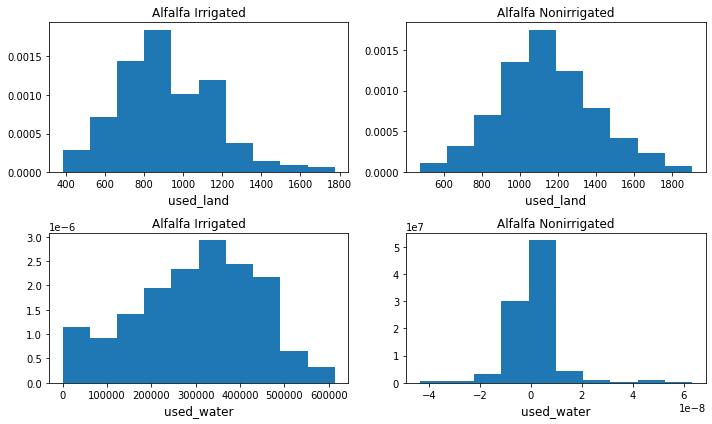

In [19]:
import os
from daWUAP.plotting import EnsembleResults

KF_OUTPUT_DIR = './kf_ensembles'
farm_id = '30023'
results_hdf5 = os.path.join(KF_OUTPUT_DIR, '%s_ensembles.h5' % str(farm_id))
ens_results = EnsembleResults(os.path.join(KF_OUTPUT_DIR, '%s_kf_info.json' % str(farm_id)))
ens_results.plot_simulation_ensemble(
    os.path.join(KF_OUTPUT_DIR, '%s_ensembles.h5' % str(farm_id)),
    ['used_land', 'used_water'], ['Alfalfa Irrigated', 'Alfalfa Nonirrigated'],
    figsize = (10, 6))

**If we want to plot either a single crop and multiple state variables or a single state variable and multiple crops, the output looks much better if we add `wrap = True`):**

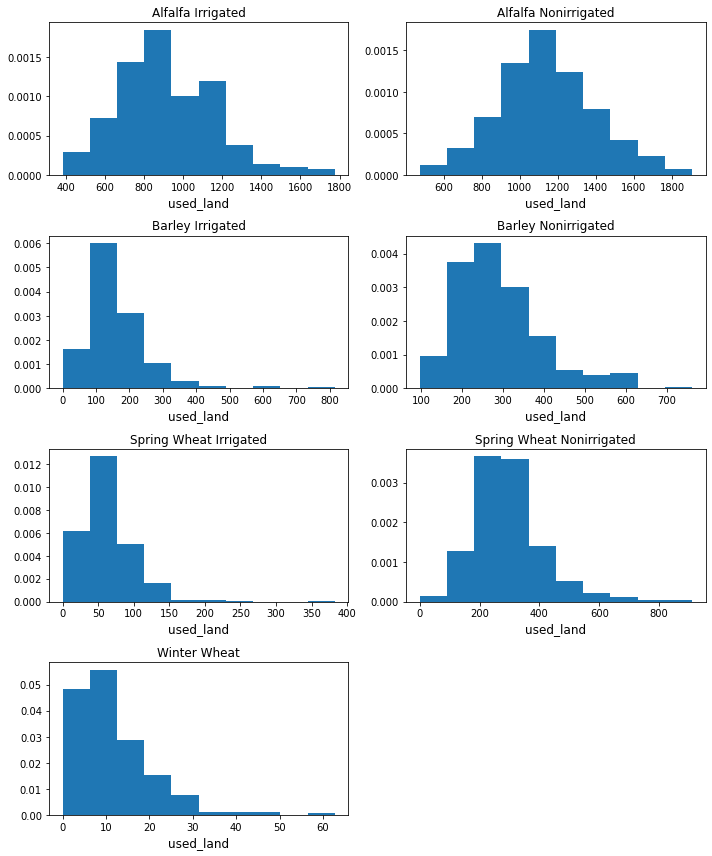

In [20]:
ens_results.plot_simulation_ensemble(results_hdf5, ['used_land'], figsize = (10, 12), wrap = True)

We can, of course, look at many state variables for many crops; this is actually the default (if `crop_list` and `state_list` were set to `None` or to multi-item lists).

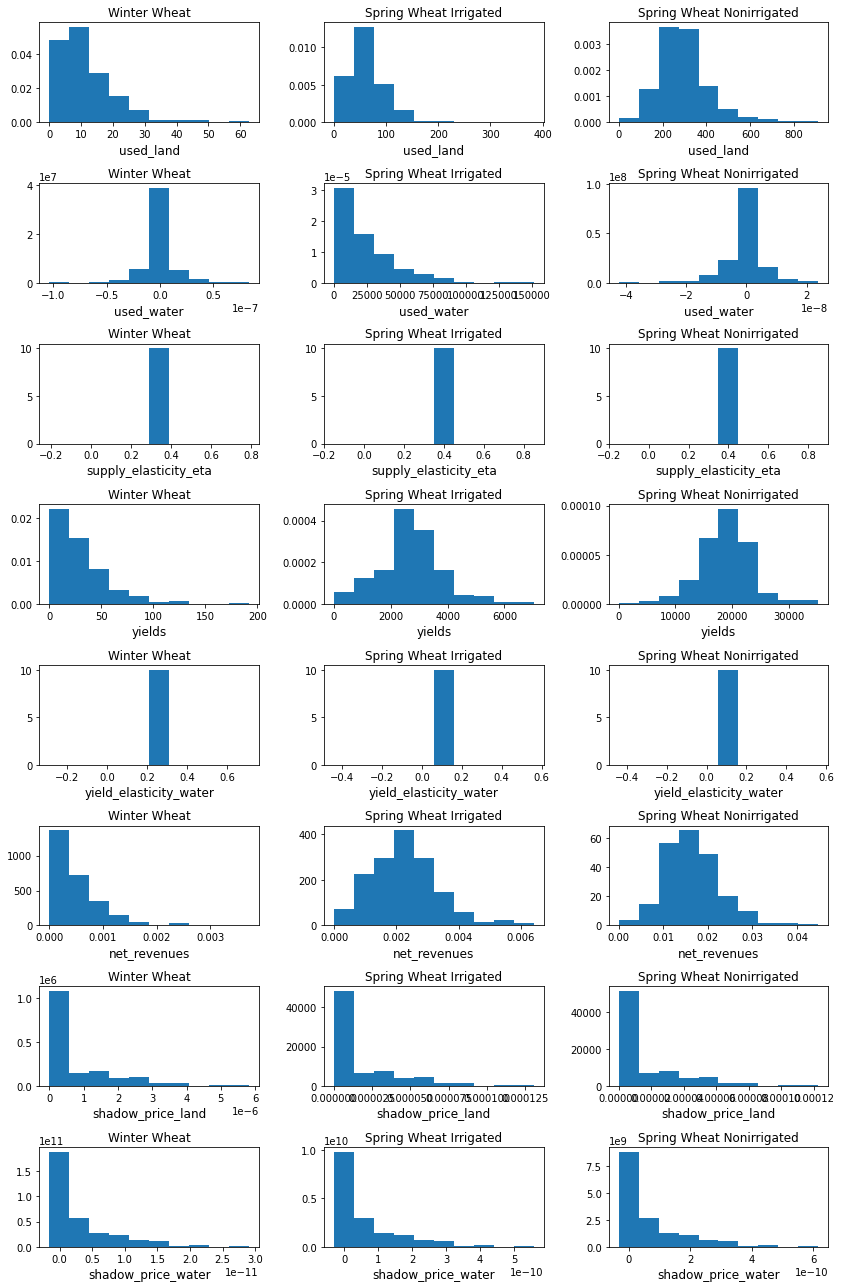

In [21]:
ens_results.plot_simulation_ensemble(
    os.path.join(KF_OUTPUT_DIR, '%s_ensembles.h5' % str(farm_id)), figsize = (12, 18),
    crop_list = ['Winter Wheat', 'Spring Wheat Irrigated', 'Spring Wheat Nonirrigated'])

### Baseline Comparison

We can examine how well our baseline scenario (simulation) matches the observed distribution of, say, land allocation by crop type.

In [22]:
import json
import numpy as np

num_of_crops = 7
farm_id = '30023'

avg_used_land = np.zeros((num_of_crops,))
for i, year in enumerate(range(2008, 2019)):
    # Open observed activity files for a given year
    with open('./observations/observations%d.json' % year) as file:
        observations = json.load(file)
    
    # Get the observation associated with the farm of interest (by its ID)
    obs = list(filter(lambda f: f['id'] == farm_id, observations)).pop()
    avg_used_land = np.add(avg_used_land, obs['mean_obs_land'])
    
avg_used_land = np.divide(avg_used_land, num_of_crops)
avg_used_land

array([2333.93026305, 2579.00259409,  123.9386103 ,  242.24567541,
        202.19043911,  490.65527517,   19.38857143])

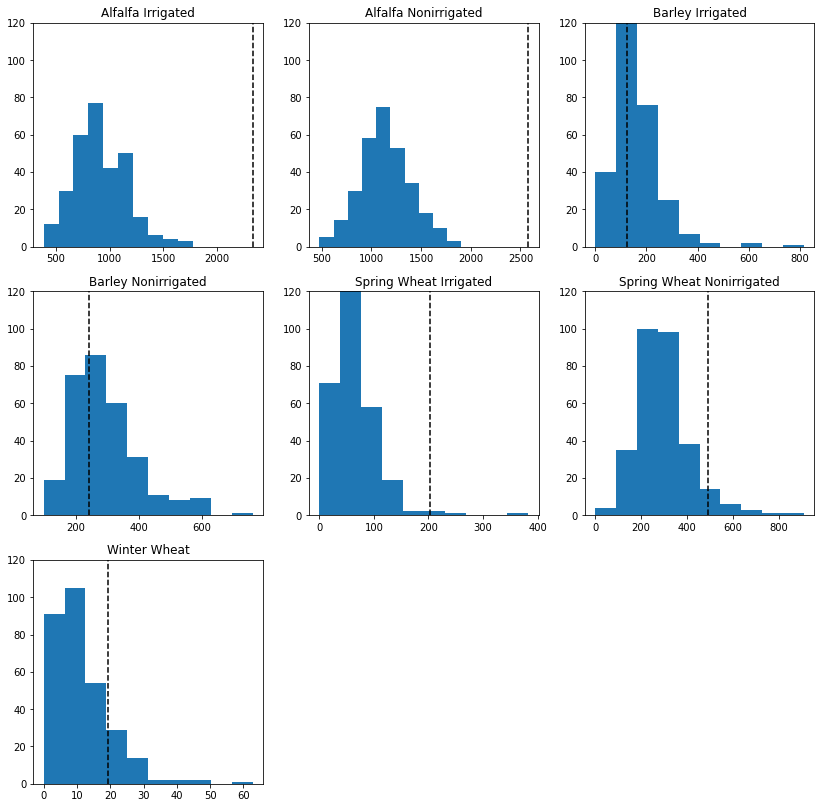

In [23]:
import pandas as pd
from matplotlib import pyplot

results = pd.read_hdf(results_hdf5)
crop_list = results.index.levels[1].tolist()

nrow, ncol = (3, 3)
fig, axes = pyplot.subplots(nrow, ncol)
fig.delaxes(axes[nrow - 1, 1]) # With an odd number of crop, delete extra subplots
fig.delaxes(axes[nrow - 1, 2]) # With an odd number of crop, delete extra subplots
fig.set_figheight(14)
fig.set_figwidth(14)
i = 0
for r in range(0, len(axes)):
    for c in range(0, ncol):
        if i >= len(crop_list):
            break # With an odd number of crops, stop plotting after last crop type
        axes[r,c].hist(results['used_land'].unstack()[crop_list[i]])
        axes[r,c].vlines(avg_used_land[i], ymin = 0, ymax = 120, colors = 'k', linestyles = 'dashed')
        axes[r,c].set_title(crop_list[i])
        axes[r,c].set_ylim(0, 120)
        i += 1

pyplot.show()